In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec

# Import Data

## Unemployment rate by state

**Note:** Unemployment data series is scraped from United States Census Bureau website for available years. For some other years, I had to type the data from Bureau of Labor Statistics News pdf file, import the csv file, and merge all data by State. 

In [2]:
def parse_url(year):
    """
    Args: a year to scrap
    Return: html list (ResultSet) 
    
    This function parses unemployment data from bls.gov site. 
    """
    year = year - 2000
    url = "https://www.bls.gov/lau/lastrk{}.htm".format(year)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'lxml')
    table = soup.find_all('table', {'class': 'regular'})
    return table

In [3]:
def parse_html_table(soup_table):
    """
    Args: html table/soup table
    Returns: data dictionary
    
    This function transforms html data to dictionary.
    """
    column_names = []

    # Get table headers
    for item in soup_table:
        for row in item.find_all('tr')[0].find_all('th'):
            column_names.append(row.get_text())
    
    column_names[0]='State'
        
    # Create an empty dictionary to store data
    data = {key:[] for key in column_names}
    
    # Get suicide rate data
    for item in soup_table:
        for row in item.find_all('tr')[3:54]:
            table_tags = row.find_all(['th', 'td'])
            {data[key].append(value.get_text()) for key, value in 
             zip(column_names, table_tags)}
    return data

In [4]:
def dict_to_df(dic_data):
    """
    Args: dictionary data
    Returns: dataframe
    
    This function transforms dict to df.
    """
    # Convert into dataframe
    df = pd.DataFrame.from_dict(dic_data)
    return df

In [5]:
def unemployment(year1, year2):
    """
    Args: 2 years as a range
    Returns: dataframe
    
    This function sparses unemployment data and return it as a df.
    """
    diff = year2 - year1 + 1

    if year1 < 2014 or year2 > 2018:
        return "Error: Only 2015 to 2018 data is available at this website"
    else:
        df_unemp = pd.DataFrame(columns=None)
        for i in range(diff):
            # append column name 
            year = year1 + i
            # scrape data from www.bls.gov & turn into df
            soup_table = parse_url(year1+i)
            dic_data = parse_html_table(soup_table)
            df = dict_to_df(dic_data)
            # rename the column
            df = df.rename(columns={"{}rate".format(year1+i): 
                "{}".format(year1+i)})
            # change data type from object to float 
            df = df.astype({str(year): float})
            if i == 0:
                df_unemp = df
            else:
                df_unemp = df_unemp.merge(df, left_on='State', 
                                          right_on='State', how='inner')
            
        # drop extra columns and District of Columnbia data at index 50
        df_unemp = df_unemp.drop(columns=['Rank_x', 'Rank_y'], index=[50])
        df_unemp.set_index('State', inplace=True)
        df_unemp = df_unemp.reindex(sorted(df_unemp.columns), axis=1)
        return df_unemp

In [6]:
def add_year_unemployment(df_unemp, dir):
    """
    Args: df and directory of file to add on
    Returns: dataframe
    
    This function adds unemployment data in .csv format to given unemployment
    data in df format.
    """
    df_unemp_added = pd.read_csv(dir)
    df_unemployment = df_unemp.merge(df_unemp_added, left_on='State', 
                                     right_on='State', how='inner')
    df_unemployment.set_index('State', inplace=True)
    df_unemployment = df_unemployment.reindex(sorted(df_unemployment.columns), 
                                              axis=1)
    return df_unemployment

## Education attainment by state

**Note:** Education attainment data is downloaded from the United States Census Bureau and imported as a csv file. 

In [7]:
def education(dir):
    """
    Args: .csv file directory
    Returns: dataframe
    
    This function takes directory for education file in .csv format
    and returns df.
    """
    df_education = pd.read_csv(dir)
    df_education.set_index('State', inplace=True)

    return df_education

## Suicide rate by state

**Note:** Suicide rate data is downloaded from the Centers for Disease Control and Prevention and imported as a csv file. 

In [8]:
def suicide_time_series(dir):
    """
    Args: .csv file directory 
    Returns: dataframe
    
    This function takes directory for suicide time series data in .csv format
    and returns df.
    """
    df_suicide_ts = pd.read_csv(dir)
    df_suicide_ts['year'].astype(int)
    return df_suicide_ts

In [9]:
def suicide(dir):
    """
    Args: .csv file directory
    Returns: dataframe
    
    This function takes directory for suicide by states in .csv format
    and returns df.
    """
    df_suicide = pd.read_csv(dir)
    df_suicide.set_index('State', inplace=True)
    return df_suicide

## GDP growth by state

**Note:** GDP growth data is downloaded from the Bureau of Economic Analysis and imported as a csv file. 

In [10]:
def gdp_growth(dir):
    """
    Args: .csv file directory
    Returns: dataframe
    
    This function takes directory for GDP in .csv format and returns df.
    """
    df_gdp = pd.read_csv(dir)
    df_gdp.set_index('State', inplace=True)
    return df_gdp

## US map by state

**Note:** US map data is imported from .json format and saved in geopandas.

In [11]:
def save_file(url, file_name):
    """
    Args: url to .json data and file_name
    Returns: opened .json file
    
    This function takes a url and opens it as given file_name given.
    """
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)


def us_map(dir):
    """
    Args: dir to .json file
    Returns: geo-dataframe
    
    This function takes US map data url in .json format and returns 
    geo-dataframe.
    """
    save_file(dir, 'us_map.json')
    country = gpd.read_file('us_map.json')
    mainland = country[(country['NAME'] != 'Alaska') & 
                       (country['NAME'] !='Hawaii')]
    return mainland

# Preliminary data analysis

## Time trend analysis

In [12]:
def vis_suicide_trend(df):
    """
    Args: df
    Returns: plot
    
    This function takes suicide rate time series dataframe, trains regression
    model on data before 2007 (data before the financial crisis) and returns 
    a plot with trend line drawn by the regression result. 
    """
    
    # all set 
    X = df["year"].values.reshape(-1,1)
    y = df["suicide_rate"].values.reshape(-1,1)
    
    # use data from 1999 to 2007 as training set 
    X_train = X[:9]
    y_train = y[:9]

    # fit simple regression model
    regressor = LinearRegression()
    regressor.fit(X_train, y_train) 

    # retrieve the intercept
    y_pred = regressor.predict(X)

    # plotting
    fig, ax = plt.subplots(1, sharex=True, figsize=(10,7))
    plt.scatter(X, y, color='black')
    plt.plot(X, y_pred, color='black', linestyle='dashed')
    ax.set_title('US suicide rate trend', fontsize=25,fontweight='bold', 
                 pad=20, color='black')
    
    # format axes
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.ylabel('Suicide rate per 100 000', fontsize=15, color='black')
    plt.xlabel('Years', fontsize=15, color='black')
    plt.xticks(fontsize=14,color='black')
    plt.yticks(fontsize=14,color='black')
    plt.grid(b=bool, which='major', axis='both')
    
    # fill in between 
    X1 = X.reshape(-1)
    y1 = y.reshape(-1)
    y2 = y_pred.reshape(-1)
    plt.fill_between(X1, y1, y2, where=y1 >= y2, interpolate=True, 
                     color='cornflowerblue', alpha=0.3)
    plt.text(2011, 12, "Above the trendline", size=15, rotation=18., 
             color='gray')
    return plt.savefig('trend.png')

## Top 3 and bottom 3 states

In [13]:
def vis_top3_bottom3(df):
    """
    Args: df
    Returns: plot
    
    This function takes suicide rate by states dataframe, and draws top 3 
    states with highest suicide rate along with bottom 3 states with 
    lowest suicide rate.
    """
    # filtering top 3 and bottom 3 states by suicide rate
    df_sorted = df.sort_values(by='2018', ascending=False)
    top_3 = df_sorted.head(3)
    bottom_3 = df_sorted.tail(3)
    top_and_bottom = top_3.append(bottom_3)

    # plotting
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_axes([0,0,1,1])
    x = top_and_bottom.index
    y = top_and_bottom['2018']
    ax.bar(x,y)
    ax.set_title('US top 3 and bottom 3 states by suicide rate', fontsize=25, 
                 fontweight='bold', pad=20, color='black')
    
    # formatting axes
    plt.ylabel('Suicide rate per 100 000', fontsize=15, color='black')
    plt.xlabel('Top 3 and bottom 3 states by suicide rate', fontsize=15, 
               color='black')
    plt.xticks(fontsize=20,color='black')
    plt.yticks(fontsize=12,color='black')
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20
    
    # adding bar numbers
    for i, v in enumerate(y):
        ax.text(i-0.1, v-2, str(v), color='white', fontweight='bold', 
                fontsize=20)
    
    # adding top 3 and top 3 texts
    ax.text(0.2,v+18, "<-------  Top 3 states  ------->", color="darkred", 
            fontweight='bold', fontsize=15)
    ax.text(3.1,v+1.8, "<-------  Bottom 3 states  ------->", color="darkred", 
            fontweight='bold', fontsize=15)
    
    # increase y axis height
    ax.set_ylim([0,28])
    
    return plt.savefig('top3_bottom3.png')

## States by suicide rate

In [14]:
def vis_states_by_suicide(df_suicide, df_map):
    """
    Args: 2 dataframes
    Returns: plot
    
    This function takes suicide rate dataframe and US map dataframe, and 
    draws US map colored each state by suicide rate. 
    """
    # find average suicide rate over the past 5 years for each state
    df_suicide_avg = pd.DataFrame(columns=['suicide'])
    df_suicide_avg['suicide'] = df_suicide.mean(axis=1)
    merged = df_map.merge(df_suicide_avg, how='inner', left_on="NAME", 
                          right_on="State", left_index=True)
    
    # plotting
    fig, ax = plt.subplots(1, figsize=(30,15))
    # draw all countries in gray
    merged.plot(ax=ax, column='suicide', legend=True, cmap='Greys')  
    # label each state
    merged['coords'] = merged['geometry'].apply(lambda x: 
        x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        text = plt.annotate(s=row['NAME'], xy=row['coords'],
                            horizontalalignment='center')
        text.set_fontsize(13)
        text.set_color('gray')

    # change axes name, fontsize, color
    plt.xticks(fontsize=20,color='black')
    plt.yticks(fontsize=20,color='black')

    ax.set_title('Average suicide rate across the US', fontsize=35, 
                 fontweight='bold', pad=20, color='black')
    return plt.savefig('states_map.png')

# Socioeconomic factor analysis

## Top 10 states and corresponding socioeconomic factors

In [15]:
def vis_top_or_bottom(df_map, df_suicide, df_unemployment, df_education, 
                      df_gdp, top_or_bottom, number):
    """
    Args: 5 dataframes, 1 argument for top or bottom, and a number to show 
    what number of top or bottom states to show
    Returns: plot
    
    This function takes suicide rate data and it's corresponding socioeconomic
    factors' data and returns a graph that shows either top or bottom certain 
    number of states along with the trend in socioeconomic factors. 
    """
    merged = df_map.merge(df_suicide, how='inner', left_on="NAME", 
                          right_on="State", left_index=True)
    # rank states by suicide rate 
    df_suicide_avg = pd.DataFrame(columns=['suicide'])
    df_suicide_avg['suicide'] = df_suicide.mean(axis=1)
    df_suicide_sorted = df_suicide_avg.sort_values(by='suicide', 
                                                   ascending=False)
    if top_or_bottom == "top":
        show = df_suicide_sorted[:number].index
    else: 
        num = 51-number
        show = df_suicide_sorted[num:].index
    # create the figure GridSpec
    fig = plt.figure(figsize=(15,15))
    fig.patch.set_facecolor('lavender')
    
    gs = GridSpec(3,4, hspace=-0.2,wspace=0.2, height_ratios=[2, 1, 1])
    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[-1, 0])
    ax3 = fig.add_subplot(gs[-1, 1])
    ax4 = fig.add_subplot(gs[-1, 2])
    ax5 = fig.add_subplot(gs[-1, 3])
    
    # visualize US states in gray
    merged.plot(ax=ax1, color='#EEEEEE')
    
    # label each state
    merged['coords'] = merged['geometry'].apply(lambda x: 
        x.representative_point().coords[:])
    merged['coords'] = [coords[0] for coords in merged['coords']]
    for idx, row in merged.iterrows():
        text = ax1.annotate(s=row['NAME'], xy=row['coords'],
                            horizontalalignment='center')
        text.set_fontsize(9)
        text.set_color('black')
        
        
    # top states in dark gray
    states = merged.loc[show,:]
    states.plot(ax=ax1, color='gray', legend=True)
    
    # Suicide rate graph
    df1 = pd.DataFrame(columns=['Suicide rate', 'National average'])
    df1['Suicide rate'] = df_suicide.loc[show,:].mean()[1:]
    df1['National average'] = df_suicide.mean()
    
    # Unemployment rate graph
    df2 = pd.DataFrame(columns=['Unemployment rate', 'National average'])
    df2['Unemployment rate'] = df_unemployment.loc[show,:].mean()[1:]
    df2['National average'] = df_unemployment.mean()
    
    # GDP graph
    df3 = pd.DataFrame(columns=['GDP growth rate', 'National average'])
    df3['GDP growth rate'] = df_education.loc[show,:].mean()[1:]
    df3['National average'] = df_education.mean()
    
    # Education graph
    df4 = pd.DataFrame(columns=['Education attainment', 'National average'])
    df4['Education attainment'] = df_gdp.loc[show,:].mean()[1:]
    df4['National average'] = df_gdp.mean()
    
    # Plot all
    df1.plot(color=['black','red'], ax=ax2)
    df2.plot(color=['black','red'], ax=ax3)
    df3.plot(color=['black','red'], ax=ax4)
    df4.plot(color=['black','red'], ax=ax5)

    if top_or_bottom == "top":
        ax1.set_title(str("{} states with highest suicide rate".format(number)
        ),fontsize=35, pad=20, color='black')
    else:
        ax1.set_title(str("{} states with lowest suicide rate".format(number)
        ), fontsize=35, pad=20, color='black')
    return plt.savefig('{}_suicide_factors.png'.format(top_or_bottom))

### Main function

/Users/saruul/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


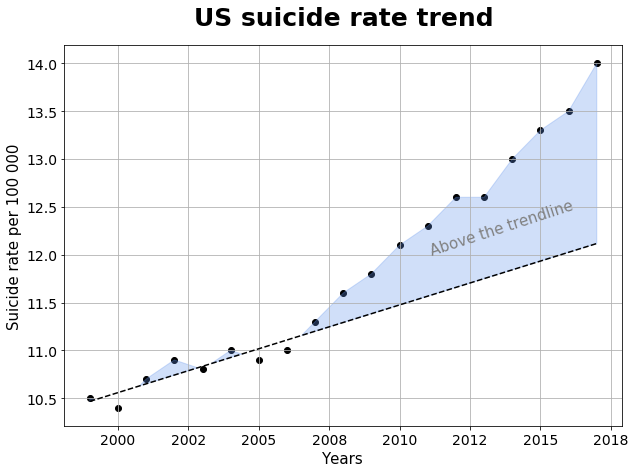

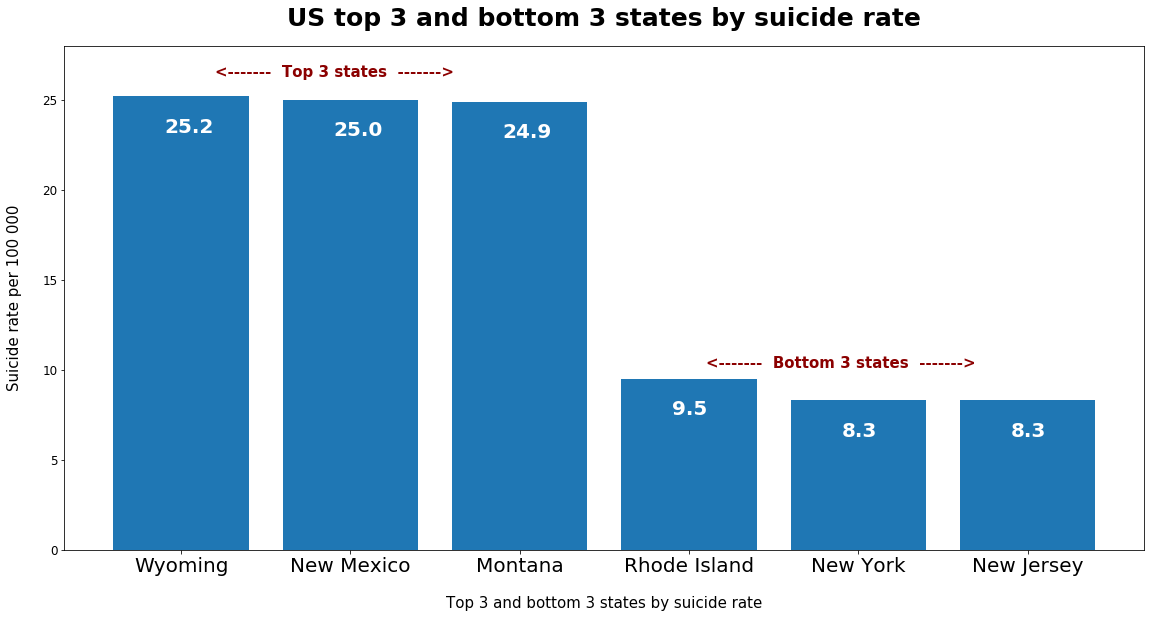

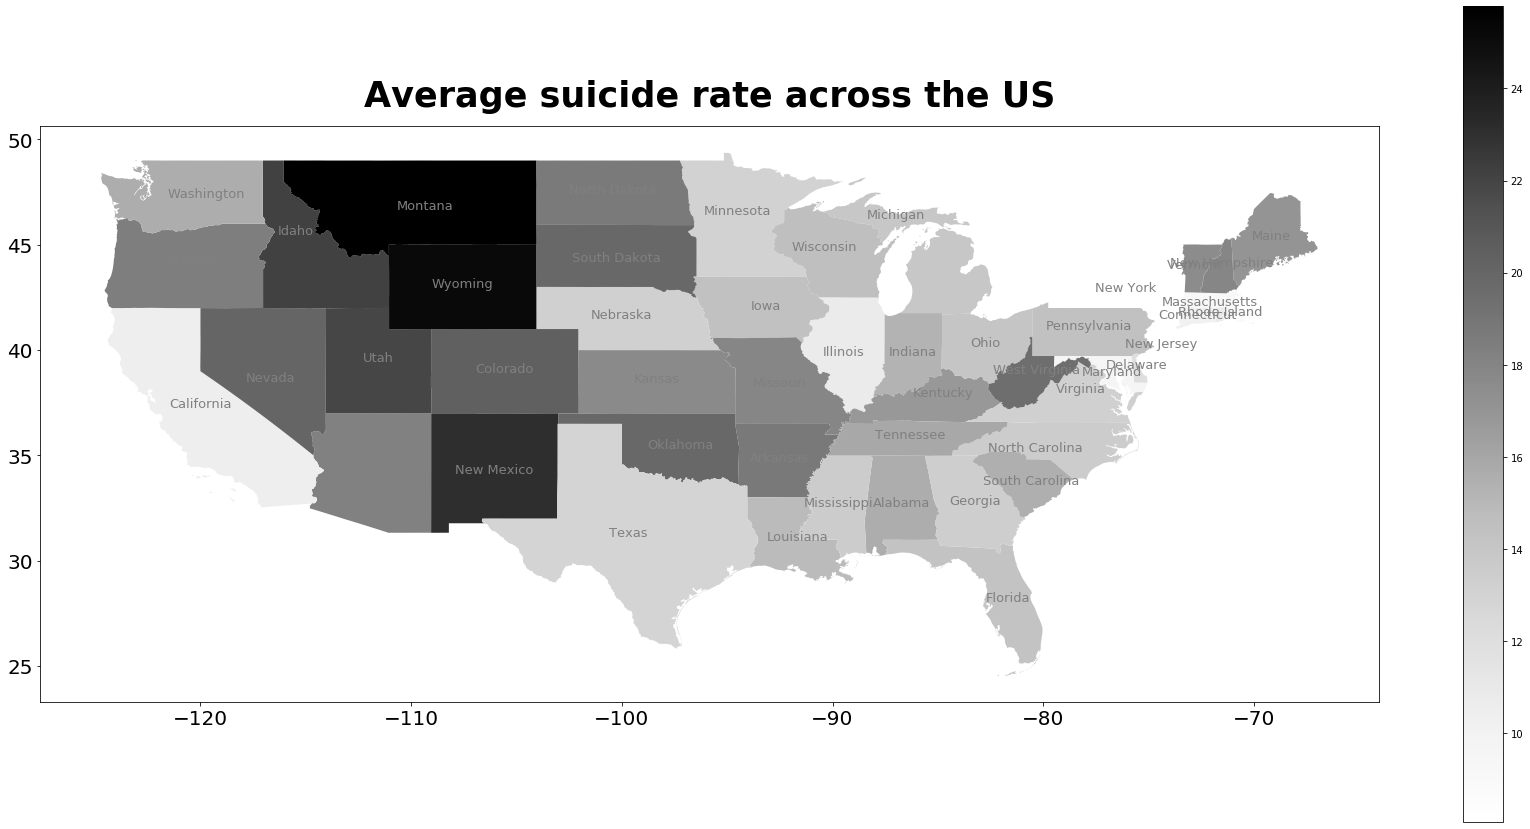

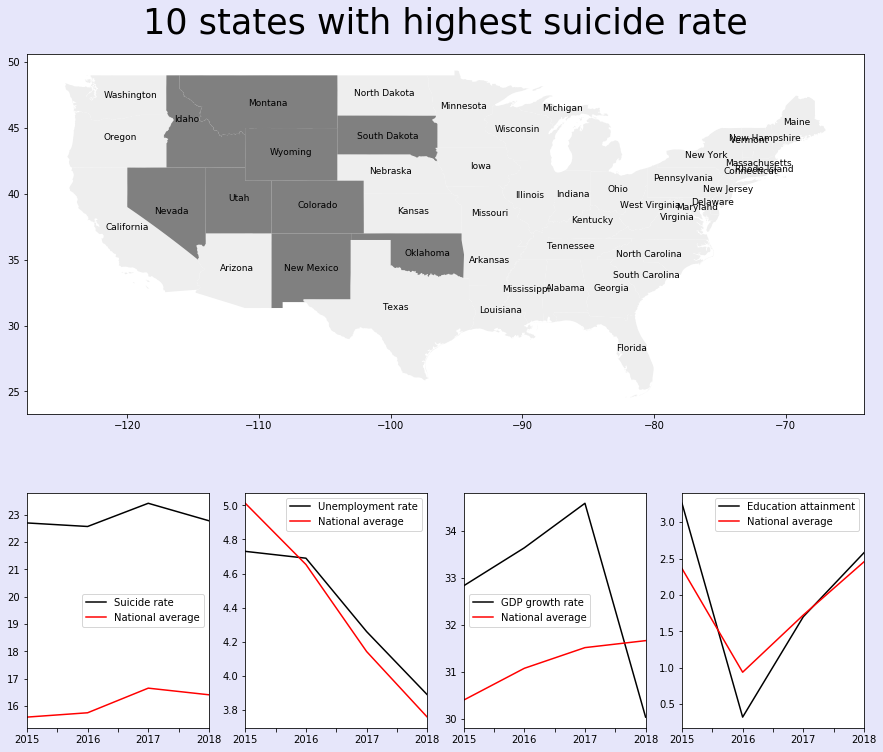

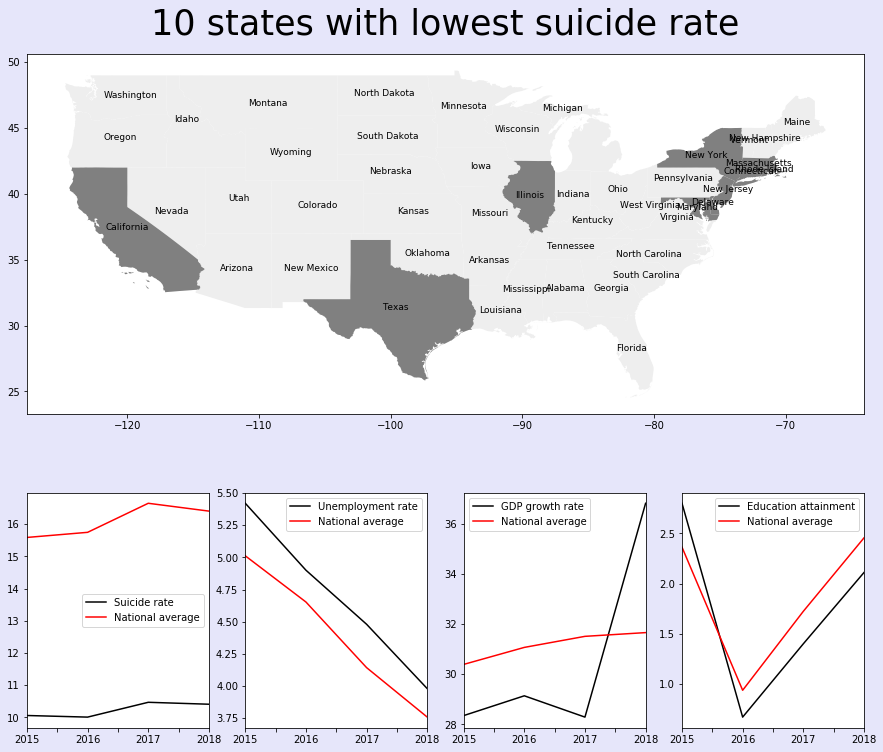

In [17]:
def main():
    
    # PART 0

    ## file directories 
    dir_to_data_folder = "/Users/saruul/Documents/1_u_of_washington/year2_quarter2/cse163_python/project/final_result/data"
    dir_unemployment = (dir_to_data_folder+"/unemployment.csv")
    dir_education = (dir_to_data_folder+"/education.csv")
    dir_suicide_ts = (dir_to_data_folder+"/suicide_ts.csv")
    dir_suicide = (dir_to_data_folder+"/suicide.csv")
    dir_gdp = (dir_to_data_folder+"/gdp_growth.csv")
    dir_map = ("https://courses.cs.washington.edu/courses/"+
    "cse163/19sp/files/lectures/05-13/gz_2010_us_040_00_5m.json")

    # PART 1 

    ## i) scrape and import unemployment data as dataframe
    df_unemp_scraped = unemployment(2015, 2018) 
    df_unemployment = add_year_unemployment(df_unemp_scraped, dir_unemployment)
        # add new row for the overall US data
    df_unemployment.loc['United States',:] = [6.2, 5.3, 4.9, 4.4, 3.9]

    ## ii)     education attainment (from .csv file)
    df_education = education(dir_education)
    ## iii)    suicide rate (from .csv file)
    df_suicide_ts = suicide_time_series(dir_suicide_ts)
    df_suicide = suicide(dir_suicide)
    ## iv)     GDP growth (from .csv file)
    df_gdp = gdp_growth(dir_gdp)
    ## v)      US map (from .json file)
    df_map = us_map(dir_map)

    # PART 2
    
    ## i)   Time trend analysis
    vis1 = vis_suicide_trend(df_suicide_ts)
    ## ii)  Top 3 and bottom 3 states
    vis2 = vis_top3_bottom3(df_suicide)
    ## iii) States by suicide rate
    vis3 = vis_states_by_suicide(df_suicide, df_map)
    
    # PART 3
    
    ## i)  Top 10 states and corresponding socioeconomic factors
    vis4 = vis_top_or_bottom(df_map, df_suicide, df_unemployment, df_education,
                             df_gdp, "top", 10)
    ## ii) Bottom 10 states and corresponding socioeconomic factors
    vis5 = vis_top_or_bottom(df_map, df_suicide, df_unemployment, df_education,
                             df_gdp, "bottom", 10)
    
    return vis1, vis2, vis3, vis4, vis5


if __name__ == '__main__':
    main()